# Homework 3

## Imports and Utilities
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [6]:
from collections import namedtuple
import itertools
import numpy as np


class RV:
    """A random variable with a finite domain.

    Example usage:
      A = RV("A", ["x", "y", "z"])
      print(A.domain)
      print(A.dim)
      B = RV("B", [(0, 0), (0, 1), (0, 2)]))
      print(B.domain)
      print(B.dim)
    """

    def __init__(self, name, domain):
        """Initialize a RV.

        Args:
          name: str name for the RV.
          domain: list or tuple of domain values.
        """
        assert isinstance(domain, (list, tuple))
        self.name = name
        self.domain = domain
        self.dim = len(domain)

    def __hash__(self):
        return hash((self.name, tuple(self.domain)))

    def __eq__(self, other):
        return self.name == other.name and self.domain == other.domain

    def __repr__(self):
        return f"RV('{self.name}', {self.domain})"


class Potential:
    """A potential over RVs.

    Example usage:
      A = RV("varA", ["x", "y", "z"])
      B = RV("varB", [0, 1])
      table = np.array([
        [0.1, 0.0],
        [0.4, 0.9],
        [0.5, 0.1]
      ])
      potential = Potential([A, B], table)
      print(potential.rvs)
      print(potential.get(("y", 0)))
      print(potential.get_by_rvs({A: "y", B: 0}))
      print(potential.get_by_names({"varA": "y", "varB": 0}))
    """

    def __init__(self, rvs, table):
        """Create a potential from a list of RVs and a numpy array.

        The order of the random variables corresponds to the axes
        of the numpy array.

        Args:
          rvs: A list or tuple of RVs.
          array: A numpy array of potential values.

        Returns:
          potential: A Potential."""
        assert isinstance(rvs, (tuple, list))
        assert len(rvs) == len(table.shape)
        assert all(rv.dim == dim for (rv, dim) in zip(rvs, table.shape))
        assert isinstance(table, np.ndarray)
        self.rvs = rvs
        self.table = table

    def set(self, assignment, new_value):
        """Given a complete assignment and a value, update table.

        Args:
          assignment: A tuple of values in the order of self.rv.
          new_value: A new value to add to the table.

        Returns:
          value: The value in self.table.
        """
        assert len(assignment) == len(self.rvs)
        indices = [None for _ in self.rvs]
        for index, value in enumerate(assignment):
            rv = self.rvs[index]
            indices[index] = rv.domain.index(value)
        self.table[tuple(indices)] = new_value

    def get(self, assignment):
        """Given a complete assignment of values, lookup table value.

        Args:
          assignment: A tuple of values in the order of self.rv.

        Returns:
          value: The value in self.table.
        """
        assert len(assignment) == len(self.rvs)
        indices = [None for _ in self.rvs]
        for index, value in enumerate(assignment):
            rv = self.rvs[index]
            indices[index] = rv.domain.index(value)
        return self.table[tuple(indices)]

    def get_by_rvs(self, rvs_to_vals):
        """Given a complete assignment of RVs to values, lookup table value.

        Args:
          rvs_to_values: A dict from RVs to values in their domains.

        Returns:
          value: The value in self.table.
        """
        assert set(rvs_to_vals.keys()) == set(self.rvs)
        indices = [None for _ in self.rvs]
        for rv, value in rvs_to_vals.items():
            index = self.rvs.index(rv)
            indices[index] = rv.domain.index(value)
        return self.table[tuple(indices)]

    def get_by_names(self, rv_name_dict):
        """Given a dict from RV names (strs) to assignments,
        return the corresponding value in the potential table.

        Args:
          rv_name_dict: A dict from str names to values.
          potential: A Potential.

        Returns:
          value: The float value from potential.table.
        """
        assert len(rv_name_dict) == len(self.rvs)
        rv_name_to_rv = {rv.name: rv for rv in self.rvs}
        rvs_to_vals = {}
        for rv_name, value in rv_name_dict.items():
            rv = rv_name_to_rv[rv_name]
            rvs_to_vals[rv] = value
        return self.get_by_rvs(rvs_to_vals)

    def __hash__(self):
        return hash(tuple(self.rvs)) ^ hash(self.table.tobytes())

    def __eq__(self, other):
        return hash(self) == hash(other)

    def __neq__(self, other):
        return not (self == other)

    def allclose(self, other, decimals=6):
        """Check whether two potentials are (nearly) equal.
        """
        if set(self.rvs) != set(other.rvs):
            raise ValueError("Can only compare potentials with the same RVs.")
        new_idxs = [other.rvs.index(rv) for rv in self.rvs]
        trans_table2 = np.transpose(other.table, new_idxs)
        assert self.table.shape == trans_table2.shape
        return np.allclose(self.table, trans_table2)


def neighbor_dict(rvs, potentials):
    """This helper function creates a mapping.
      - For each random variable rv, neighbors[rv] is a set of potentials that involve this RV.
      - For each potential pot, neighbors[pot] is a set of random variables involved in this potential.
    """
    neighbors = {v: set() for v in rvs + potentials}
    for p in potentials:
        for v in p.rvs:
            neighbors[p].add(v)
            neighbors[v].add(p)
    return neighbors


def marginalize(potential, rvs):
    '''Create a new potential where each rv in rvs has been marginalized out.

    Args:
      potential: A Potential.
      rvs: A set of random variables in the potential to be marginalized out.

    Returns:
      new_potential: A Potential.
    '''
    # Create new rvs
    new_rvs = [v for v in potential.rvs if v not in rvs]

    # Get rv indexes
    idxs = tuple([potential.rvs.index(rv) for rv in rvs])

    # Create new table
    new_table = potential.table.sum(axis=idxs)

    # Finish potential
    return Potential(rvs=new_rvs, table=new_table)


def multiply_potentials(potentials):
    '''Multiply potentials together.

    Args:
      potentials: A list of Potentials.

    Returns:
      result: A new Potential.
    '''

    # Collect all random variables
    rvs = set()
    for pot in potentials:
        rvs |= set(pot.rvs)
    rvs = list(rvs)

    # Initialize result table
    table = np.empty([rv.dim for rv in rvs])

    # Initialize result potential
    result = Potential(rvs, table)

    # Iterate over assignments in the new potential
    for assignment in iter_joint_values(rvs):
        value = 1.
        for pot in potentials:
            # Get the sub-assignment
            sub_assignment = get_sub_assignment(rvs, assignment, pot.rvs)
            # Compute product
            value *= pot.get(sub_assignment)
        # Add value to result table
        result.set(assignment, value)

    # Finalize potential
    return result


# Undirected graphical models described in 3.1 and 3.2.

def create_mrf_3_1():
    """Create the undirected graphical model (MRF) in section 3.1."""
    A, B = RV("A", [0, 1]), RV("B", [0, 1])
    rvs = [A, B]
    potentials = [
        Potential([A], np.array([1.0, 3.0])),
        Potential([B], np.array([1.0, 2.0])),
        Potential([A, B], np.array([
            [1.0, 2.0],
            [3.0, 4.0]
        ]))
    ]
    return rvs, potentials


def create_mrf_3_2():
    """Create the undirected graphical model (MRF) in section 3.2."""
    A, B, C, D = RV("A", [0, 1]), RV("B", [0, 1]), RV("C", [0, 1])
    rvs = [A, B, C, D]
    potentials = [
        Potential([A, B], np.array([
            [1.0, 2.0],
            [3.0, 4.0]
        ])),
        Potential([B, C], np.array([
            [1.0, 1.0],
            [2.0, 2.0]
        ]))
    ]
    return rvs, potentials


InferenceProblem = namedtuple("InferenceProblem",
                              ["rvs", "potentials", "query", "evidence"])


############### Testing problems ###############

def create_debug_2vars_problem(version):
    """A simple problem with two random variables"""
    A = RV("A", [0, 1])
    B = RV("B", [0, 1, 2])
    rvs = [A, B]
    p_a_given_b = Potential([A, B], np.array([
        [0.9, 0.15, 0.44],
        [0.1, 0.85, 0.56],
    ]))
    p_b = Potential([B], np.array([0.7, 0.2, 0.1]))
    pots = [p_a_given_b, p_b]
    if version == 1:
        query = {A: 1}
        evidence = {B: 1}
    elif version == 2:
        query = {B: 1}
        evidence = {A: 1}
    else:
        assert version == 3
        query = {A: 1, B: 1}
        evidence = {}
    return InferenceProblem(rvs, pots, query, evidence)


def create_california_problem(version):
    """Holmes, watson, earthquakes, radios, oh my...
    """
    p_b = np.array([0.99, 0.01])
    p_e = np.array([0.97, 0.03])
    p_re = np.array([
        [0.98, 0.01],
        [0.02, 0.99],
    ])
    p_aeb = np.zeros((2, 2, 2))
    p_aeb[1, 0, 0] = 0.01
    p_aeb[0, 0, 0] = 1. - 0.01
    p_aeb[1, 0, 1] = 0.2
    p_aeb[0, 0, 1] = 1. - 0.2
    p_aeb[1, 1, 0] = 0.95
    p_aeb[0, 1, 0] = 1. - 0.95
    p_aeb[1, 1, 1] = 0.96
    p_aeb[0, 1, 1] = 1. - 0.96

    A = RV("Alarm", [0, 1])
    B = RV("Burglar", [0, 1])
    E = RV("Earthquake", [0, 1])
    R = RV("Radio", [0, 1])
    rvs = [A, B, E, R]
    pots = [
        Potential([B], p_b),
        Potential([E], p_e),
        Potential([R, E], p_re),
        Potential([A, E, B], p_aeb)
    ]
    if version == "alarm":
        # P(B=1 | A=1)
        query = {B: 1}
        evidence = {A: 1}
    else:
        assert version == "alarm and earthquake"
        # P(B=1 | A=1, R=1)
        query = {B: 1}
        evidence = {A: 1, R: 1}
    return InferenceProblem(rvs, pots, query, evidence)


def create_binary_chain_problem(num_vars):
    """A simple binary chain designed to stress test inference
    """
    rvs = [RV(f"X{i}", [0, 1]) for i in range(num_vars)]
    pots = []
    for rv_t, rv_t1 in zip(rvs[:-1], rvs[1:]):
        pot = Potential([rv_t, rv_t1], np.array([
            [0.9, 0.1],
            [0.1, 0.9],
        ]))
        pots.append(pot)
    query = {rvs[0]: 0}
    evidence = {}
    return InferenceProblem(rvs, pots, query, evidence)


def iter_joint_values(rvs):
    """Iterates over joint assignments for a list of RVs.

    Returns an iterator that can be used in a for loop.

    Example usage:
      for assignment in iter_joint_values(rvs):
        print(assignment)  # a tuple
        assert assignment[0] in rvs[0].domain

    Args:
      rvs: A list of RVs.

    Yields:
      assignment: A tuple of ints representing a joint
        assignment of the random variables.
    """
    domains = [rv.domain for rv in rvs]
    return itertools.product(*domains)


def get_sub_assignment(rvs, assignment, sub_rvs):
    """Given an assignment of rvs to values, get a subassignment,
    that is, a sub-tuple of the given assignment involving only
    the given sub_rvs.

    Example usage:
      x = RV("x", [0, 1])
      y = RV("y", ["a", "b"])
      z = RV("z", [3, 5])
      rvs = (x, y, z)
      assignment = (0, "b", 3)
      sub_rvs = (z, x)
      sub_assignment = get_sub_assignment(rvs, assignment, sub_rvs)
      assert sub_assignment == (3, 0)

    Args:
      rvs: A tuple or list of RVs.
      assignment: A tuple or list of values.
      sub_rvs: A tuple or list of RVs, a subset of rvs.

    Returns:
      sub_assignment: A tuple of values.
    """
    assert set(sub_rvs).issubset(set(rvs))
    sub_assignment = []
    for rv in sub_rvs:
        idx = rvs.index(rv)
        val = assignment[idx]
        sub_assignment.append(val)
    return tuple(sub_assignment)


def run_belief_prop(problem):
    """Run inference with belief propagation.

    Calls `run_single_marginal_bp`, which is for
    you to implement.

    You will not need to use this function in your code.

    Args:
      problem: InferenceProblem
      max_iters: int
         Maximum number of iterations for each BP call.
    Returns:
      result: float
        Answer to the query in the problem
    """
    # Convert evidence to potentials
    problem = convert_evidence_to_potentials(problem)
    # Convert joint queries into a sequence of marginal queries
    problems = []
    # Set up arbitrary order for chain rule
    queries = sorted(problem.query.items(), key=lambda i: i[0].name)
    for i, (rv, val) in enumerate(queries):
        # P(rv = val | previous vals)
        new_query = {rv: val}
        new_evidence = dict(queries[:i])
        new_problem = InferenceProblem(problem.rvs,
                                       problem.potentials,
                                       new_query, new_evidence)
        new_problem = convert_evidence_to_potentials(new_problem)
        problems.append(new_problem)
    # Run individual problems
    result = 1.
    for p in problems:
        (query_rv, query_val), = p.query.items()
        p_result = run_single_marginal_bp(query_rv, query_val,
                                          p.rvs, p.potentials)
        result *= p_result
    return result


def convert_evidence_to_potentials(problem):
    """Create singleton potentials to account for evidence.

    Helper for run_belief_prop. You will not need to use this.
    """
    new_problem = InferenceProblem(problem.rvs,
                                   [pot for pot in problem.potentials],
                                   problem.query.copy(), {})
    for rv, val in problem.evidence.items():
        # Create singleton potential
        table = np.zeros(rv.dim)
        table[rv.domain.index(val)] = 1.
        new_potential = Potential([rv], table)
        new_problem.potentials.append(new_potential)
    return new_problem





## Variable Elimination


### Question
Implement Variable Elimination given a list of Potentials and a Variable order. You may use the functions multiply_potentials and marginalize from last week's homework.

For reference, our solution is **13** line(s) of code.

In [7]:
def variable_elimination(potentials, order):
  '''Given a list of potentials and a list of RVs, perform variable elimination in the provided order.

  Args:
    potentials: A list of Potentials
    order: A list of RVs

  Returns:
    result: A new list of Potentials
  '''
  for rv in order:
      relevant_potentials = [pot for pot in potentials if rv in pot.rvs]

      if not relevant_potentials:
          continue

      new_potential = multiply_potentials(relevant_potentials)

      marginalized_potential = marginalize(new_potential, {rv})

      potentials = [pot for pot in potentials if pot not in relevant_potentials]
      potentials.append(marginalized_potential)

  return potentials

### Tests

In [8]:
def variable_elimination_test0():
  A = RV("varA", [0, 1, 2])
  B = RV("varB", [0, 1])
  C = RV("varC", [0, 1, 2])
  table_AB = np.array([
    [0.1, 0.0],
    [0.4, 0.9],
    [0.5, 0.1]
  ])
  table_BC = np.array([
      [0.2, 0.8, 0.1],
      [0.8, 0.2, 0.9],
  ])
  potential_AB = Potential([A, B], table_AB)
  potential_BC = Potential([B, C], table_BC)

  potentials = [potential_AB, potential_BC]
  order = [B]

  results = variable_elimination(potentials, order)
  assert len(results) == 1

  expected_variables = [A, C]
  expected_table = np.array([[0.02, 0.8, 0.18], [0.08, 0.5, 0.42], [0.01, 0.85, 0.14]])
  assert sorted(results[0].rvs, key = lambda x: x.name) == expected_variables
  assert np.allclose(results[0].table, expected_table) or np.allclose(results[0].table, expected_table.T)
  print('Test 1 Passed!')

def variable_elimination_test1():
  A = RV("varA", [0, 1, 2])
  B = RV("varB", [0, 1])
  C = RV("varC", [0, 1, 2])
  D = RV("varD", [0, 1, 2, 3, 4])
  table_AB = np.array([
    [0.1, 0.0],
    [0.4, 0.9],
    [0.5, 0.1]
  ])
  table_BC = np.array([
      [0.2, 0.8, 0.1],
      [0.8, 0.2, 0.9],
  ])
  table_AC = np.array([
      [0.1, 0.2, 0.4],
      [0.4, 0.2, 0.3],
      [0.5, 0.6, 0.3],
  ])
  table_BD = np.array([
      [1, 0, 1, 0, 1],
      [0, 1, 0, 1, 0],
  ])
  potential_AB = Potential([A, B], table_AB)
  potential_BC = Potential([B, C], table_BC)
  potential_AC = Potential([A, C], table_AC)
  potential_BD = Potential([B, D], table_BD)
  potentials = [potential_AB, potential_BC, potential_AC, potential_BD]
  order = [A, C]
  results = variable_elimination(potentials, order)
  assert len(results) == 2

  variable_lists = []
  table_lists = []
  for resulting_potential in results:
    variable_lists.append(sorted([rv.name for rv in resulting_potential.rvs]))
    table_lists.append(resulting_potential.table)
  variable_lists = sorted(variable_lists)
  expected_variable_list = [['varB'], ['varB', 'varD']]
  assert expected_variable_list == variable_lists
  indices_of_tables = []
  same_tables = 0
  for table in table_lists:
    if table.shape == (2, 5):
      assert np.allclose(table, table_BD)
      same_tables += 1
    elif table.shape == (2,):
      assert np.allclose(table, np.array([0.435, 0.646]))
      same_tables += 1
    else:
      assert False
  assert same_tables == 2
  print('Test 2 Passed!')

variable_elimination_test0()
variable_elimination_test1()

Test 1 Passed!
Test 2 Passed!


## Conditioning Warmup


### Utilities

### Viterbi helper function
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [9]:
def condition_potential(potential, condition):
    """Given a potential and an assignment of one or more RVs,
        create a new potential representing the conditional.

    Example usage:
        A, B = RV('A', ["x", "y", "z"]), RV('B', [0, 1])
        pot = Potential([A, B],
            np.array([
                [1, 0],
                [0, 1],
                [0, 0],
        ]))
        condition = {A: "y"}
        result = condition_potential(pot, condition)
        assert result.rvs == [B]
        assert result.get_by_rvs({B: 0}) == 0
        assert result.get_by_rvs({B: 1}) == 1

    Args:
        potential: A Potential.
        condition: A dict from RVs to values.

    Returns:
        conditional_potential: A Potential.
    """
    new_rvs = [rv for rv in potential.rvs if rv not in condition]
    idxs = []
    for rv in potential.rvs:
        if rv in condition:
            value = condition[rv]
            idx = rv.domain.index(value)
        else:
            idx = slice(None)
        idxs.append(idx)
    new_table = potential.table[tuple(idxs)].copy()
    return Potential(new_rvs, new_table)


def normalize_potential(potential):
    """Normalize the values of a potential so they sum to 1.

    Args:
        potential: A Potential.

    Returns:
        new_potential: A Potential.
    """
    denom = potential.table.sum()
    if denom == 0:
        raise Exception("WARNING: tried to normalize an all-zeros potential.")
    return Potential(potential.rvs, potential.table / denom)


def max_potential(potential, rv=None):
    """Create a new potential where rv has been maximized out.

    If rv is None, then this function returns the max
    over all assignments in the potential.

    Example usage:
        A, B = RV('A', ["x", "y", "z"]), RV('B', [0, 1])
        pot = Potential([A, B],
            np.array([
                [1., 5.],
                [2., 6.],
                [3., 4.],
        ]))
        assert max_potential(pot) == 6.
        pot1 = max_potential(pot, rv=A)
        assert pot1.rvs == [B]
        assert pot1.get_by_rvs({B: 0}) == 3
        assert pot1.get_by_rvs({B: 1}) == 6
        pot2 = max_potential(pot, rv=B)
        assert pot2.rvs == [A]
        assert pot2.get_by_rvs({A: "x"}) == 5
        assert pot2.get_by_rvs({A: "y"}) == 6
        assert pot2.get_by_rvs({A: "z"}) == 4

    Args:
        potential: A Potential.
        rv: A random variables in the potential or None.

    Returns:
        new_potential: A Potential.
    """
    if rv is None:
        return potential.table.max()
    axis = potential.rvs.index(rv)
    new_table = potential.table.max(axis=axis)
    new_rvs = list(potential.rvs)
    new_rvs.remove(rv)
    return Potential(new_rvs, new_table)


def argmax_potential(potential, rv=None):
    """Create a new "potential" where the values are domain assignments
    of the given rv that lead to maximum values.

    If rv is None, then this function returns the argmax assignment
    over all assignments in the potential.

    Example usage:
        A, B = RV('A', ["x", "y", "z"]), RV('B', [0, 1])
        pot = Potential([A, B],
            np.array([
                [1., 5.],
                [2., 0.],
                [3., 4.],
        ]))
        assert argmax_potential(pot) == ("x", 1)
        pot1 = argmax_potential(pot, rv=A)
        assert pot1.rvs == [B]
        assert pot1.get_by_rvs({B: 0}) == "z"
        assert pot1.get_by_rvs({B: 1}) == "x"
        pot2 = argmax_potential(pot, rv=B)
        assert pot2.rvs == [A]
        assert pot2.get_by_rvs({A: "x"}) == 1
        assert pot2.get_by_rvs({A: "y"}) == 0
        assert pot2.get_by_rvs({A: "z"}) == 1

    Args:
        potential: A Potential.
        rv: A random variable in the potential or None.

    Returns:
        new_potential: A Potential.
    """
    if rv is None:
        idxs = np.unravel_index(potential.table.argmax(), potential.table.shape)
        return tuple(v.domain[idx] for v, idx in zip(potential.rvs, idxs))
    axis = potential.rvs.index(rv)
    new_table_idxs = potential.table.argmax(axis=axis)
    new_table = np.empty(new_table_idxs.shape, dtype=object)
    for idx, val in np.ndenumerate(new_table_idxs):
        new_table[idx] = rv.domain[val]
    new_rvs = list(potential.rvs)
    new_rvs.remove(rv)
    return Potential(new_rvs, new_table)


HMM = namedtuple("HMM", [
    "state_rvs",  # A list of RVs, one per timestep
    "observation_rvs",  # A list of RVs, one per timestep
    "transition_potentials",  # A list of Potentials, one per transition
    "observation_potentials",  # A list of Potentials, one per timestep
    "initial_distribution"  # A single Potential
])


def create_hmm(obstacle_map, num_timesteps, noise_prob=0.):
    """Converts a map into an HMM.

    Creates the state RVs, the observation RVs, the transition potentials,
    and the observation potentials.

    You should not need to use this; it's used in tests.

    Args:
      obstacle_map: A list of lists of ints; see example and
          description in `create_state_variable`.
      num_timesteps: An int number of timesteps, must be >= 1.
      noise_prob: Observation noise parameter.s

    Returns:
      problem: An HMM.
    """
    assert num_timesteps >= 1

    # Create variables
    state_rvs = []
    observation_rvs = []
    for t in range(num_timesteps):
        state_t = create_state_variable(obstacle_map, f"state{t}")
        obs_t = create_observation_variable(f"observation{t}")
        state_rvs.append(state_t)
        observation_rvs.append(obs_t)

    # Create observation potentials
    observation_potentials = []
    for state, obs in zip(state_rvs, observation_rvs):
        obs_pot_t = create_observation_potential(obstacle_map, state, obs,
                                                 noise_prob=noise_prob)
        observation_potentials.append(obs_pot_t)

    # Create transition potentials
    transition_potentials = []
    if num_timesteps > 1:
        for state_t, state_t1 in zip(state_rvs[:-1], state_rvs[1:]):
            trans_pot_t = create_transition_potential(obstacle_map, state_t, state_t1)
            transition_potentials.append(trans_pot_t)

    # Create (uniform) initial state distribution
    init_state_rv = state_rvs[0]
    table = np.ones((init_state_rv.dim,)) / init_state_rv.dim
    initial_distribution = Potential([init_state_rv], table)

    return HMM(state_rvs, observation_rvs, transition_potentials,
               observation_potentials, initial_distribution)

def normalize(arr):
    total = np.sum(arr)
    if total == 0:
      return arr
    return arr / total

### Question
Given a potential and a variable that occurs in it, return a new potential conditioned on the specified variable having value 0.

For reference, our solution is **2** line(s) of code.

In [10]:
def conditioning_warmup(potential, rv):
    """Given a potential and a variable that occurs in it, return a new
    potential conditioned on the specified variable having value 0.

    Args:
      potential: Potential
      rv: A RV in the potential that has 0 in its domain.

    Returns:
      new_potential: Potential
    """
    condition = {rv: 0}
    return condition_potential(potential, condition)

### Tests

In [11]:
def conditioning_warmup_test():
    A = RV("A", [0, 1])
    B = RV("B", [0, 1])
    pot = Potential(
        rvs=[A, B],
        table=np.array([
            [0.98, 0.01],
            [0.02, 0.99],
        ])
    )
    cond_pot = conditioning_warmup(pot, B)
    assert set(cond_pot.rvs) == {A}
    assert cond_pot.get((0,)) == 0.98
    assert cond_pot.get((1,)) == 0.02

conditioning_warmup_test()

print('Tests passed.')

Tests passed.


## HMM


### Question
Write a function that creates a random variable for a state at a given time step in an obstacle HMM. The domain of the state variable should be a list of (row, col) indices into the map. Only free positions (not obstacles) should be included in the domain of the state variable. See docstring for more description.

For reference, our solution is **4** line(s) of code.

In [14]:
def create_state_variable(obstacle_map, name):
    """Creates a RV for the HMM state.

    The state can be any position in the map.

    Example map:
      obstacle_map = [
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
      ]

    Ones are obstacles and zeros are free positions.

    The domain of the state variable should be a list of (row, col)
    indices into the map. Only free positions (not obstacles) should
    be included in the domain of the state variable.

    The domain should be in row-major order. For example, an empty
    2x2 obstacle map should lead to the domain:

      [(0, 0), (0, 1), (1, 0), (1, 1)].

    Args:
      obstacle_map: A list of lists of ints, see example above.
      name: A str name for the state variable.

    Returns:
      state_var: A RV as described above.
    """
    domain = []
    for row in range(len(obstacle_map)):
        for col in range(len(obstacle_map[0])):
            if obstacle_map[row][col] == 0:
                domain.append((row, col))
    return RV(name, domain)

### Tests

In [15]:
def create_state_variable_test():
    map1 = [[0, 1, 0],
            [1, 0, 0]]
    rv = create_state_variable(map1, "current_state")
    assert rv.name == "current_state"
    assert rv.dim == 4
    assert rv.domain == [(0, 0), (0, 2), (1, 1), (1, 2)]

create_state_variable_test()

print('Tests passed.')

Tests passed.


## Transition potential creation


### Question
Write a function that creates a potential for the transition distribution between states $s_{t}$ and $s_{t+1}$. Refer to the previous question for more information about the state variables and their domains.

For reference, our solution is **13** line(s) of code.

In [16]:
def create_transition_potential(obstacle_map, st, st1):
    """Write a function to create a potential for the transition from state s_t
    to s_{t+1}, in an HMM that corresponds to the map.

    Transitions are uniformly distributed amongst the robot's current
    location and the neighboring free (not obstacle) locations, where
    neighboring = 4 cardinal directions (up, down, left, right).

    Hint: remember that if we have a potential with two variables A and B,
    with dimension N and M, then the potential table will be a numpy array
    of shape (N, M). Furthermore, the potential value for the i^{th} domain
    value of A and the j^{th} domain value of B will be table[i, j]. With
    this in mind, you may find it useful to use the following pattern in
    your code somewhere:

    ```
    for i, (prev_r, prev_c) in enumerate(st.domain):
      ...
      for j, (next_r, next_c) in enumerate(st1.domain):
        ...
        table[i, j] = ...
    ```

    Args:
      st: An RV representing the state at time t.
      st1: An RV representing the state at time t+1.
      obstacle_map: A list of lists of ints;
          see example and description in `create_state_variable`.

    Returns:
      potential: A Potential for the transition between st and st1.
    """
    table = np.zeros((st.dim, st1.dim))
    for i, (prev_r, prev_c) in enumerate(st.domain):
      dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
      # check candidate neighbors
      neighbors = [(prev_r+dr, prev_c+dc) for dr, dc in dirs]
      neighbors.append((prev_r, prev_c))
      valid = []

      # check if any of the candidate neighbors are free and actually in the domain of st1
      for j, (next_r, next_c) in enumerate(st1.domain):
        if (next_r, next_c) in neighbors:
          valid.append(((next_r, next_c), j))

      for (next_r, next_c), j in valid:
        table[i, j] = 1. / len(valid)

    return Potential([st, st1], table)



### Tests

In [17]:
def create_transition_potential_test():
    map1 = [[0, 0, 0],
            [1, 0, 1]]
    s0 = create_state_variable(map1, "state_0")
    s1 = create_state_variable(map1, "state_1")
    pot = create_transition_potential(map1, s0, s1)
    assert set(pot.rvs) == {s0, s1}
    assert pot.get_by_names({"state_0": (0, 0), "state_1": (0, 0)}) == 0.5
    assert pot.get_by_names({"state_0": (0, 0), "state_1": (0, 1)}) == 0.5
    assert pot.get_by_names({"state_0": (0, 0), "state_1": (1, 1)}) == 0.
    assert pot.get_by_names({"state_0": (0, 1), "state_1": (1, 1)}) == 0.25
    assert pot.get_by_names({"state_0": (0, 1), "state_1": (0, 1)}) == 0.25
    assert pot.get_by_names({"state_0": (0, 1), "state_1": (0, 2)}) == 0.25
    assert pot.get_by_names({"state_0": (0, 1), "state_1": (0, 0)}) == 0.25
    assert pot.get_by_names({"state_0": (1, 1), "state_1": (0, 0)}) == 0.
    assert pot.get_by_names({"state_0": (1, 1), "state_1": (0, 1)}) == 0.5

create_transition_potential_test()

print('Tests passed.')

Tests passed.


## Observation variable creation


### Question
Write a function that creates a random variable for an observation at a given time step in an obstacle HMM. See docstring for description.

For reference, our solution is **3** line(s) of code.

In [19]:
def create_observation_variable(name):
    """Creates a RV for the HMM observation with the given name.

    Observations are a 4-tuple that list which directions have obstacles,
    in order [N E S W], with a 1 for an obstacle and 0 for no obstacle.

    Observations that are "off the map" are 1, as though they are obstacles.

    For instance, in the following map:

      obstacle_map = [
        [0, 1],
        [0, 0],
      ]

    if there were no observation noise, then the observation for the top left
    location would be (1, 1, 0, 1).

    The domain of the observation variable should be a list of 4-tuples.

    Hint: you may find it useful to use `itertools.product`. For example,
    see what happens with `list(itertools.product(["foo", "bar"], repeat=2))`.

    Args:
      name: A str name for the variable.

    Returns:
      zt: A RV as described above.
    """

    domain = list(itertools.product([0, 1], repeat=4))
    return RV(name, domain)

### Tests

In [20]:
def create_observation_variable_test():
    rv = create_observation_variable("obs")
    assert rv.name == "obs"
    assert rv.dim == 2 ** 4
    assert set(rv.domain) == {
        (0, 0, 0, 0), (1, 0, 0, 0), (0, 1, 0, 0), (1, 1, 0, 0),
        (0, 0, 1, 0), (1, 0, 1, 0), (0, 1, 1, 0), (1, 1, 1, 0),
        (0, 0, 0, 1), (1, 0, 0, 1), (0, 1, 0, 1), (1, 1, 0, 1),
        (0, 0, 1, 1), (1, 0, 1, 1), (0, 1, 1, 1), (1, 1, 1, 1),
    }

create_observation_variable_test()

print('Tests passed.')

Tests passed.


## Observation potential creation


### Question
Write a function that creates a potential for the observation distribution between $s_{t}$ and $z_{t}$.

For reference, our solution is **29** line(s) of code.

In [21]:
def create_observation_potential(obstacle_map, state_rv, observation_rv,
                                 noise_prob=0.):
    '''Write a function to create a potential between state_rv
    and observation_rv in an HMM that corresponds to the map.

    You can assume that state_rv was created by `create_state_variable`
    and observation_rv was created by `create_observation_variable`.

    See `create_observation_variable` for a description of the
    observation model. Recall the order is [N E S W].

    If noise_prob = 0., then the observations are noise-free. That is,
    you observe 0 if there is a free space and 1 otherwise.

    In general, for each of the four observation entries, with
    probability 1 - noise_prob, the entry will be "correct"; with
    probability noise_prob, the entry will be incorrect, that is,
    the opposite of the true occupancy.

    So if the noise-free observation would be (1, 0, 0, 1), then
    the probability of observation (1, 1, 0, 1) would be
    noise_prob*(1 - noise_prob)^3.

    Args:
      obstacle_map: A list of lists of ints;
          see example and description in `create_state_variable`.
      state_rv: An RV representing the state at time t.
      observation_rv: An RV representing the observation at time t.
      noise_prob: A float between 0 and 1 indicating the probability
          that an observation flips.

    Returns:
      potential: A Potential for the distribution between st and zt.
    '''
    table = np.zeros((state_rv.dim, observation_rv.dim))

    for i, (r, c) in enumerate(state_rv.domain):
        obs = []

        # collect the actual obs
        for dr, dc in [(-1,0),(0,1),(1,0),(0,-1)]:
            nr, nc = r+dr, c+dc
            if 0 <= nr < len(obstacle_map) and 0 <= nc < len(obstacle_map[0]):
                obs.append(obstacle_map[nr][nc])
            else: obs.append(1)

        # for each element in the obs there's a 1-noise_prob probability that its actually correct, so for each cand obs in the domain we have to update its actual probability
        for j, cand_obs in enumerate(observation_rv.domain):
            p = 1.0
            for c, o in zip(cand_obs, obs):
                if c == o:
                    p *= (1 - noise_prob)
                else:
                    p *= noise_prob
            table[i, j] = p

    return Potential([state_rv, observation_rv], table)


### Tests

In [22]:
def create_observation_potential_test1():
    map1 = [[0, 0, 0],
            [1, 0, 1]]
    s0 = create_state_variable(map1, "state_0")
    z0 = create_observation_variable("obs_0")
    pot = create_observation_potential(map1, s0, z0)
    assert set(pot.rvs) == {s0, z0}
    assert pot.get_by_names({"state_0": (0, 0), "obs_0": (1, 0, 1, 1)}) == 1.
    assert pot.get_by_names({"state_0": (0, 0), "obs_0": (1, 1, 0, 1)}) == 0.
    assert pot.get_by_names({"state_0": (0, 1), "obs_0": (1, 0, 0, 0)}) == 1.
    assert pot.get_by_names({"state_0": (0, 2), "obs_0": (1, 1, 1, 0)}) == 1.
    assert pot.get_by_names({"state_0": (1, 1), "obs_0": (0, 1, 1, 1)}) == 1.

create_observation_potential_test1()


def create_observation_potential_test2():
    map1 = [[0, 0, 0],
            [1, 0, 1]]
    s0 = create_state_variable(map1, "state_0")
    z0 = create_observation_variable("obs_0")
    pot = create_observation_potential(map1, s0, z0, noise_prob=0.25)
    assert set(pot.rvs) == {s0, z0}
    assert pot.get_by_names({"state_0": (0, 0), "obs_0": (1, 0, 1, 1)}) == 0.75 * 0.75 * 0.75 * 0.75
    assert pot.get_by_names({"state_0": (0, 0), "obs_0": (1, 1, 0, 1)}) == 0.75 * 0.25 * 0.25 * 0.75
    assert pot.get_by_names({"state_0": (0, 1), "obs_0": (1, 0, 0, 0)}) == 0.75 * 0.75 * 0.75 * 0.75
    assert pot.get_by_names({"state_0": (0, 1), "obs_0": (0, 0, 0, 0)}) == 0.25 * 0.75 * 0.75 * 0.75

create_observation_potential_test2()

print('Tests passed.')

Tests passed.


## Viterbi Decoding


### Question
Complete the implementation of Viterbi decoding. Note: in general, it is a good idea for numerical stability to implement Viterbi in log space. However, for the purpose of this homework, we are not expecting your implementation to be in log space. Moreover, the provided helper functions (e.g., `multiply_potentials`) assume that you are _not_ working in log space.

For reference, our solution is **38** line(s) of code.

In [150]:
# def run_viterbi(hmm, observations):
#     '''Run the Viterbi algorithm to compute the most likely state
#     assignments given observations.

#     Normalize the messages after each step to avoid numerical instability.

#     Args:
#       hmm: An HMM.
#       observations: A list of observation values.

#     Returns:
#       most_likely_states: A list of state values.
#     '''

#     T = len(hmm.state_rvs) # == len(observations)
#     # find number of possible states for the timestep. domain is same for all timesteps
#     S = len(hmm.state_rvs[0].domain)

#     # Initialize tables
#     viterbi_table = np.zeros((T, S))
#     backpointers = np.zeros((T, S), dtype=int)

#     init_s = hmm.initial_distribution
#     init_o = condition_potential(hmm.observation_potentials[0], {hmm.observation_rvs[0]: observations[0]})
#     viterbi_table[0] = normalize(init_s.table * init_o.table)
#     # Recursion step
#     for t in range(1, T):
#         trans_potential = hmm.transition_potentials[t-1]
#         obs_potential = condition_potential(hmm.observation_potentials[t], {hmm.observation_rvs[t]: observations[t]})
#         for curr_state in range(S):
#             # get best probabilities for each state from previous timesteps, and multiply by transition potentials to current state. argmax to find best
#             probs = viterbi_table[t-1] * trans_potential.table[:, curr_state]
#             best_prev_state = np.argmax(probs)
#             # update this best probability to reach this state with condition of seeing this observation
#             viterbi_table[t, curr_state] = probs[best_prev_state] * obs_potential.table[curr_state]
#             backpointers[t, curr_state] = best_prev_state

#         viterbi_table[t] = normalize(viterbi_table[t])  # Normalize for numerical stability

#     # Backtracking
#     best_final_state = np.argmax(viterbi_table[-1])
#     best_path = [best_final_state]

#     for t in range(T - 1, 0, -1):
#         best_final_state = backpointers[t, best_final_state]
#         best_path.insert(0, best_final_state)

#     return [hmm.state_rvs[t].domain[state] for t, state in enumerate(best_path)]

def run_viterbi(hmm, observations):
    '''Run the Viterbi algorithm to compute the most likely state
    assignments given observations.

    Normalize the messages after each step to avoid numerical instability.

    Args:
      hmm: An HMM.
      observations: A list of observation values.

    Returns:
      most_likely_states: A list of state values.
    '''

    T = len(hmm.state_rvs) # == len(observations)
    # find number of possible states for the timestep. domain is same for all timesteps
    S = len(hmm.state_rvs[0].domain)

    # Initialize tables
    # viterbi_table = np.zeros((T, S))
    # viterbi[t] is potential whose table is a list of each state's max likelihood of being achieved at time t
    viterbi = np.empty(T, dtype=object)
    backpointers = np.zeros((T, S), dtype=int)
    path = []

    init_s = hmm.initial_distribution
    init_o = condition_potential(hmm.observation_potentials[0], {hmm.observation_rvs[0]: observations[0]})
    p = normalize_potential(multiply_potentials([init_s, init_o]))
    viterbi[0] = normalize_potential(multiply_potentials([init_s, init_o]))
    # Recursion step
    for t in range(1, T):
        trans_p = hmm.transition_potentials[t-1]
        obs_pt = condition_potential(hmm.observation_potentials[t], {hmm.observation_rvs[t]: observations[t]})
        table = np.zeros(S)
        for curr_state in range(S):
            state_val = hmm.state_rvs[t].domain[curr_state]
            # get best probabilities for each state from previous timesteps, and multiply by transition potentials to current state
            # argmax to find state t-1 that is most likely to get t
            probs = multiply_potentials([viterbi[t-1], condition_potential(trans_p, {hmm.state_rvs[t]: state_val})])
            p, prev_state_val = max_potential(probs), argmax_potential(probs)[0] # the resulting table should just be a s an assignment to hmm.state_rvs[t-1]
            # update this best probability to reach this state with condition of seeing this observation

            # max probability of reaching this state AND observation, which is just one value
            obs_pts = obs_pt.get_by_rvs({hmm.state_rvs[t]: state_val})
            table[curr_state] = p * obs_pts
            backpointers[t, curr_state] = hmm.state_rvs[t-1].domain.index(prev_state_val)

        viterbi[t] = normalize_potential(Potential([hmm.state_rvs[t]], table))  # Normalize for numerical stability

    # Backtracking
    best_final_state = hmm.state_rvs[T-1].domain.index(argmax_potential(viterbi[-1])[0])
    best_path = [best_final_state]

    for t in range(T - 1, 0, -1):
        best_final_state = backpointers[t, best_final_state]
        best_path.insert(0, best_final_state)

    return [hmm.state_rvs[t].domain[state] for t, state in enumerate(best_path)]

### Tests

In [145]:
def viterbi_test1():
    map1 = [[0, 0, 0],
            [1, 0, 1]]
    observations1 = [(1, 0, 1, 1), (1, 0, 0, 0), (1, 0, 0, 0)]
    hmm1 = create_hmm(map1, len(observations1))
    most_likely_states1 = run_viterbi(hmm1, observations1)
    assert most_likely_states1 == [(0, 0), (0, 1), (0, 1)]

viterbi_test1()


def viterbi_test2():
    map2 = [[0, 0, 0, 0, 0]]
    observations2 = [(1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 0),
                     (1, 0, 1, 0), (1, 0, 1, 0), (1, 1, 1, 0)]
    hmm2 = create_hmm(map2, len(observations2))
    most_likely_states2 = run_viterbi(hmm2, observations2)
    assert most_likely_states2 == [(0, 1), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

viterbi_test2()


def viterbi_test3():
    map3 = [[1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [1, 0, 1, 0, 1]]
    observations3 = [(0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 1), (1, 1, 1, 0)]
    hmm3 = create_hmm(map3, len(observations3), noise_prob=0.05)
    most_likely_states3 = run_viterbi(hmm3, observations3)
    assert most_likely_states3 == [(2, 3), (2, 3), (1, 3), (1, 4)]

viterbi_test3()


def viterbi_test4():
    map4 = [
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
    ]
    observations4 = [(1, 0, 1, 1), (1, 0, 0, 0), (0, 0, 0, 0), (1, 1, 0, 0)]
    hmm4 = create_hmm(map4, len(observations4), noise_prob=0.05)
    most_likely_states4 = run_viterbi(hmm4, observations4)
    assert most_likely_states4 == [(3, 0), (3, 1), (3, 2), (3, 3)]

viterbi_test4()

print('Tests passed.')

Tests passed.


## Viterbi Visualization


### Question

We have created a visualization tool for you in colab to visualize the inference result. You can run the following code blocks
and they will generate the visualized trajectory step by step, and show the comparison between the observed trajectory
as well as the "noiseless" observation.

If you are not passing the test, you can use the simple map `visualize_viterbi_test1` for debugging.
**Hint**: one debugging strategy is to modify your viterbi code and print out the likelihood you get at each step.


In [149]:
import matplotlib.pyplot as plt
from PIL import Image


def visualize_map(obstacles, current_location):
    obstacles = np.array(obstacles, dtype='int64')
    gs = 28
    output = np.zeros((gs * (obstacles.shape[0] + 2), gs * (obstacles.shape[1] + 2), 3), dtype='uint8') + 255
    output[:, :gs, :] = output[:, -gs:, :] = 0
    output[:gs, :, :] = output[-gs:, :, :] = 0
    for x, y in itertools.product(range(obstacles.shape[0]), range(obstacles.shape[1])):
        if obstacles[x, y]:
            x, y = x + 1, y + 1
            output[x * gs:x * gs + gs, y * gs:y * gs + gs, :] = 0
    x0, y0 = current_location
    for dx, dy in [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]:
        x, y = x0 + dx, y0 + dy
        x, y = x + 1, y + 1
        if 0 <= x < obstacles.shape[0] + 2 and 0 <= y < obstacles.shape[1] + 2:
            val = output[x * gs:x * gs + gs, y * gs:y * gs + gs, :]
            output[x * gs:x * gs + gs, y * gs:y * gs + gs, :] = (
                    val.astype('float32') * 0.5 +
                    np.array([255, 227, 132], dtype='float32').reshape(1, 1, 3) * 0.5
            ).astype('uint8')
    return output


def gen_groundtruth_local_observation(obstacles, current_location):
    obstacles = np.array(obstacles, dtype='int64')
    output = [0 for _ in range(4)]
    for i, (dx, dy) in enumerate([(-1, 0), (0, 1), (1, 0), (0, -1)]):
        x, y = current_location[0] + dx, current_location[1] + dy
        if 0 <= x < obstacles.shape[0] and 0 <= y < obstacles.shape[1]:
            output[i] = obstacles[x, y]
        else:
            output[i] = 1
    return output


def visualize_local_observation(observation):
    gs = 28
    obs = np.zeros((gs * 3, gs * 3, 3), dtype='uint8') + 255
    for (x, y), o in zip([(-1, 0), (0, 1), (1, 0), (0, -1)], observation):
        x, y = x + 1, y + 1
        obs[x * gs:x * gs + gs, y * gs:y * gs + gs, :] = 255 * (1 - o)
    return obs


def visualize_step(step, obstacles, current_location, observation):
    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5))
    fig.suptitle('Step: ' + str(step), fontsize=24)
    ax[0].set_title("Map | Robot: " + str(current_location), fontsize=20)
    ax[0].imshow(visualize_map(obstacles, current_location))

    ax[1].set_title("Noisy Observation", fontsize=20)
    ax[1].imshow(visualize_local_observation(observation))

    ax[2].set_title("Noiseless Observation", fontsize=20)
    ax[2].imshow(visualize_local_observation(gen_groundtruth_local_observation(obstacles, current_location)))


def visualize_viterbi_test1():
    map1 = [[0, 0, 0], [1, 0, 1]]
    observations1 = [(1, 0, 1, 1), (1, 0, 0, 0), (1, 0, 0, 0)]
    hmm1 = create_hmm(map1, len(observations1))
    most_likely_states1 = run_viterbi(hmm1, observations1)
    for i in range(len(observations1)):
        visualize_step(i, map1, most_likely_states1[i], observations1[i])


def visualize_viterbi_test4():
    map4 = [
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
    ]
    observations4 = [(1, 0, 1, 1), (1, 0, 0, 0), (0, 0, 0, 0), (1, 1, 0, 0)]
    hmm4 = create_hmm(map4, len(observations4), noise_prob=0.05)
    most_likely_states4 = run_viterbi(hmm4, observations4)
    for i in range(len(observations4)):
        visualize_step(i, map4, most_likely_states4[i], observations4[i])

This visualization visualizes the first test example. It's a very simple example and you can use it for debugging.

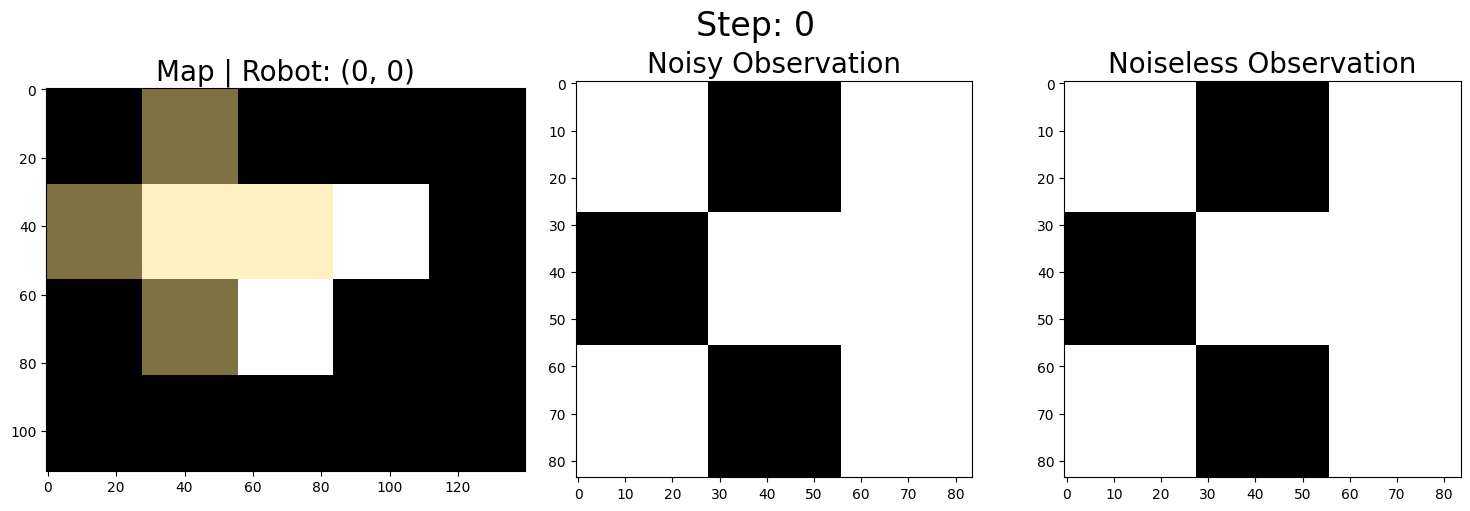

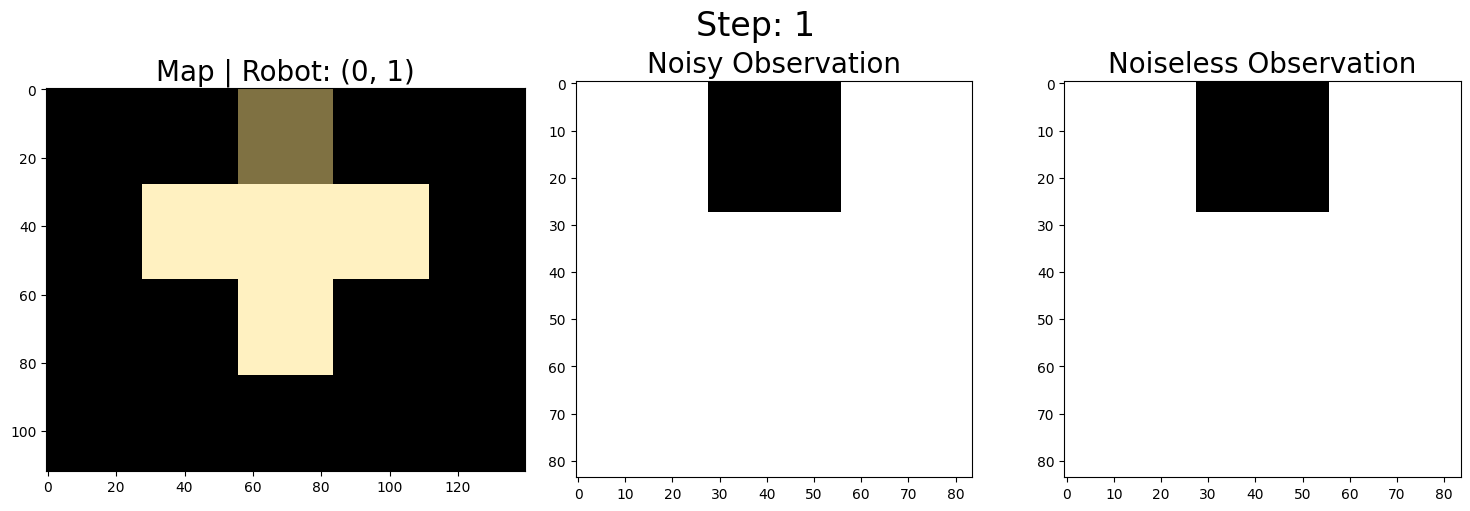

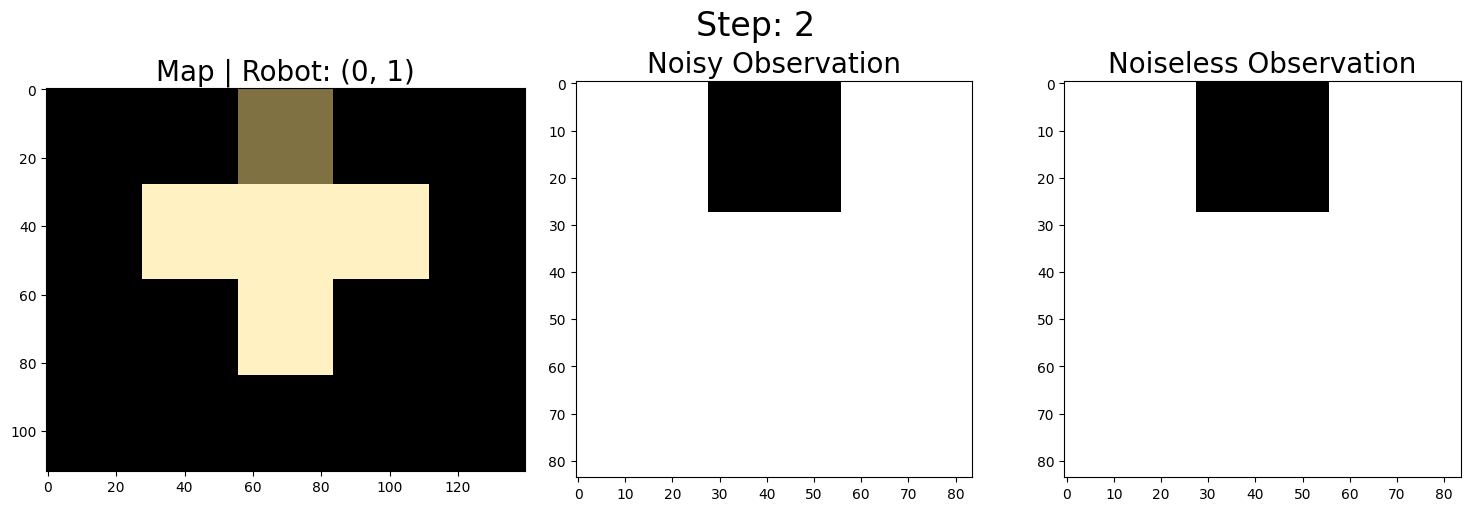

In [147]:
visualize_viterbi_test1()

This visualization considers a slightly larger map.
If you only look at the first three observation, there is an ambiguity between starting from (1, 0) and move right vs. starting from (3, 0) and move right.
This ambiguity can be resolved based on the last element in the observation.

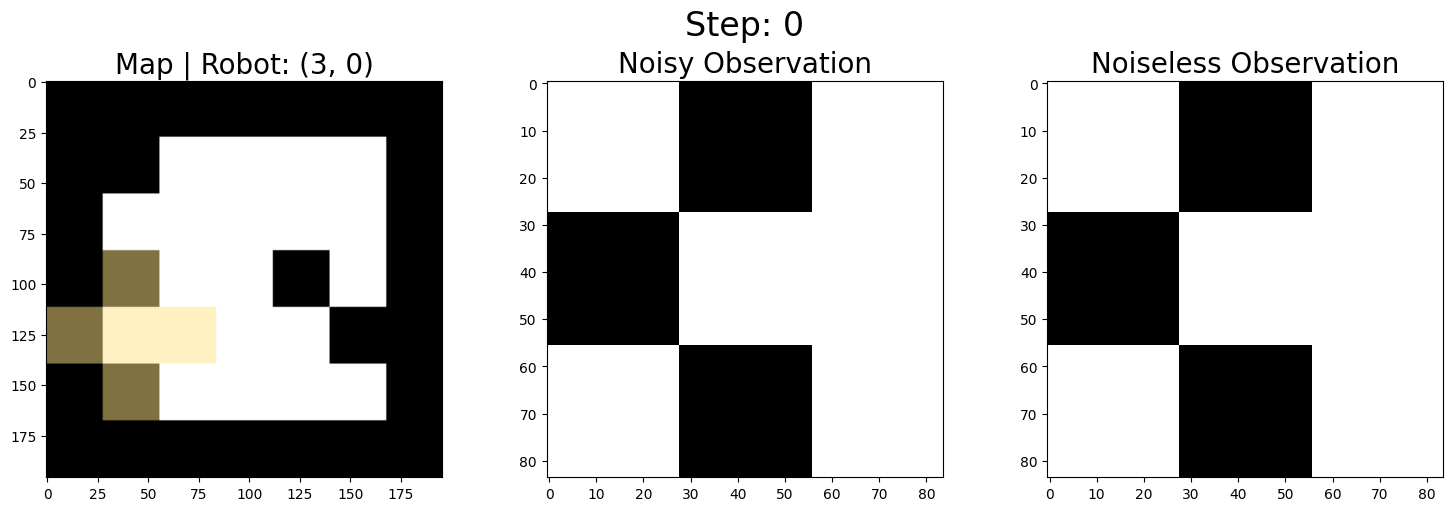

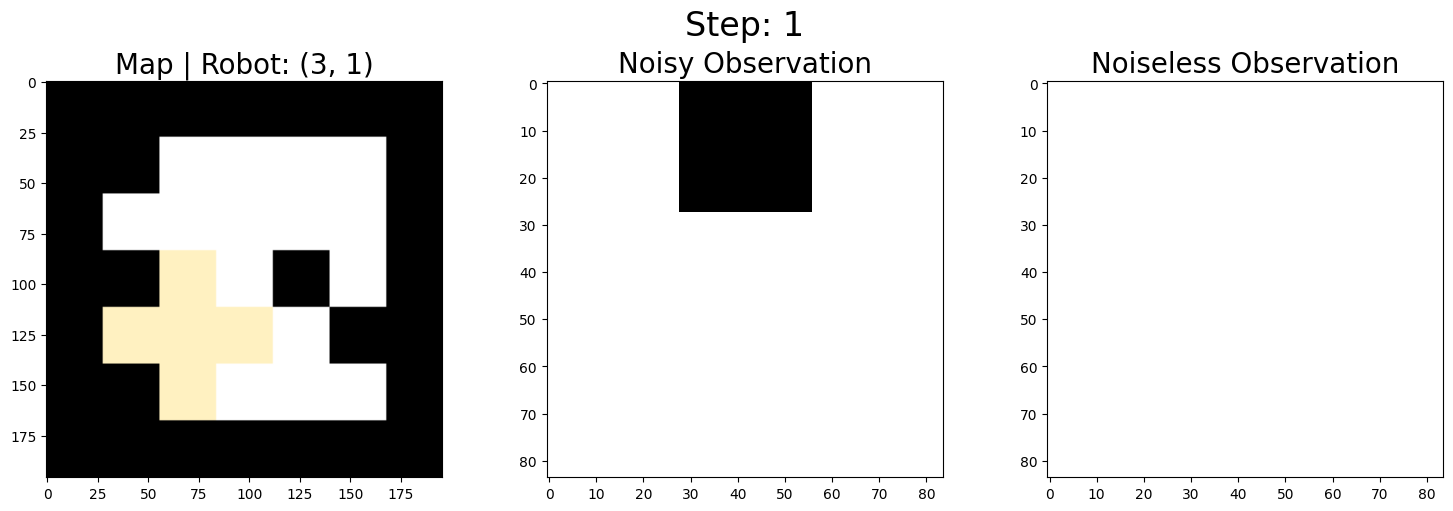

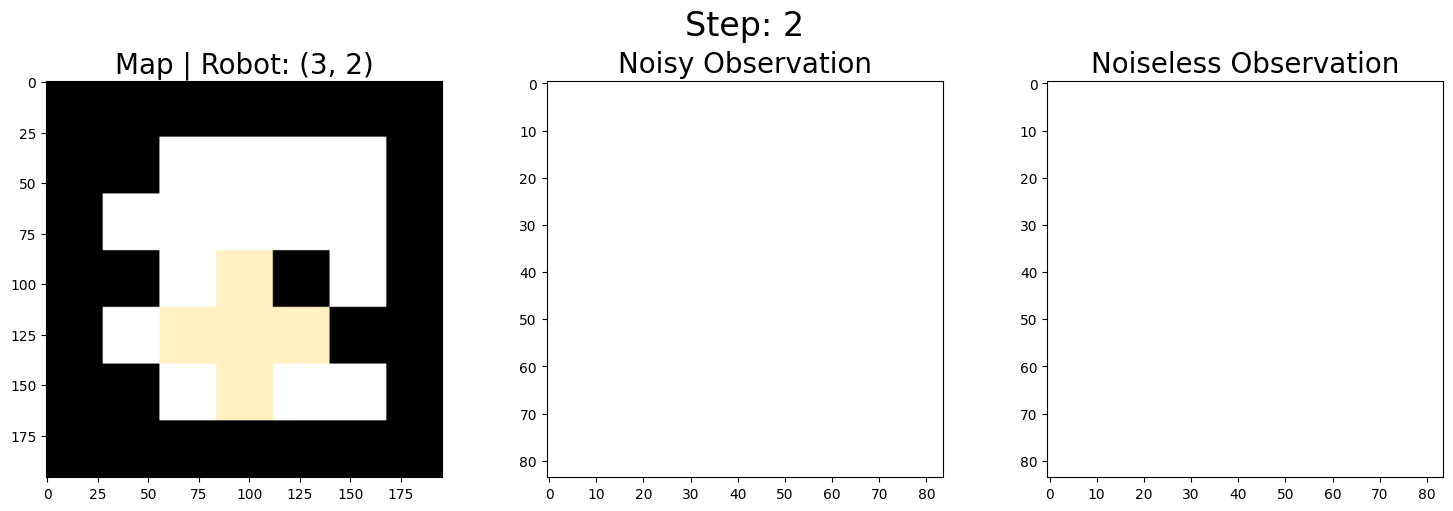

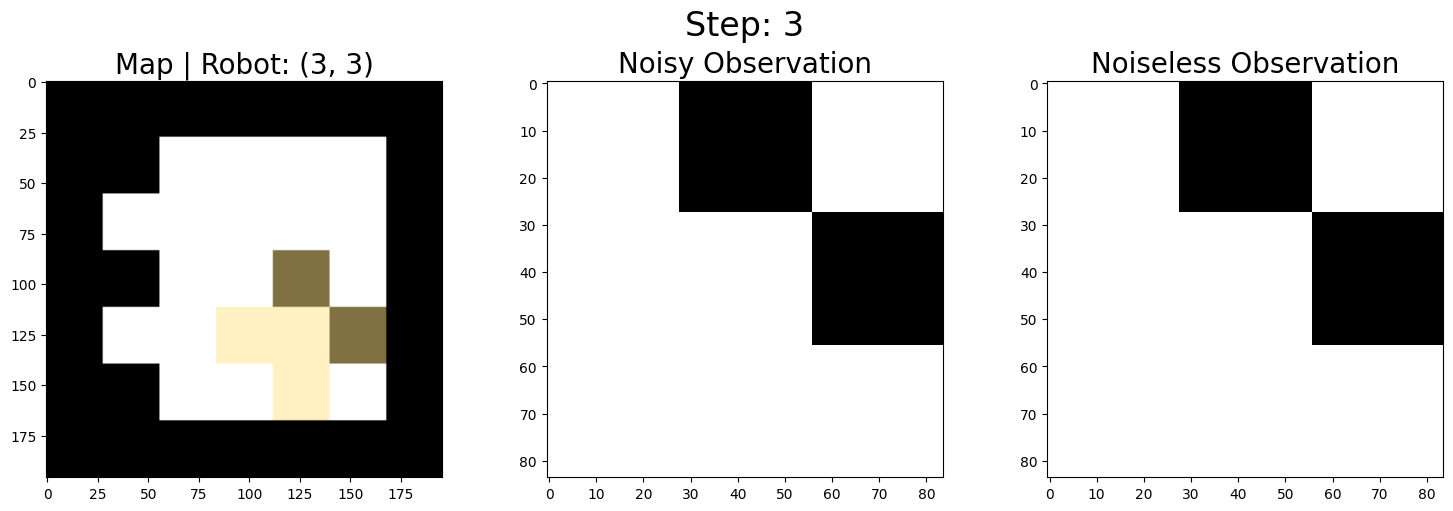

In [148]:
visualize_viterbi_test4()